In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 
from statsmodels.formula.api import ols

import scipy.stats as stats

import math 

In [3]:
df = pd.read_csv('kc_house_data.csv')
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

In [4]:
#convert column name ['date'] from object to datetime 

#might be cool to create a function that takes any column date and converts it 

df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [5]:
# Obvious issue with sqft_basement due to columns
#First attempt to convert failed due to ? marks so we need to remove them 

df['sqft_basement'].nunique() 

304

In [6]:
#replacing all ? with 0's - major assumption that requires data enrichment to correct
#

df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x==
                                             '?' else x)

df['sqft_basement'] = df['sqft_basement'].astype(float)

In [7]:
# Identify null values 

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [8]:
# Look for columns where all 3 are missing 
#This isnt a huge % of the data so we allow it 

print('Number Missing All Three:',
     len(df[(df.waterfront.isnull())
           & (df.view.isnull())
           & (df.yr_renovated.isnull())]))

Number Missing All Three: 2


In [9]:
#Repeat the same process for view which indicates how many times a house has been viewed

#We replaced all views with a median value, its safe to assume houses on the market in these areas are quite popular and viewed 
median = df['view'].median()
df['view'] = df['view'].fillna(value=median)#Waterfront 0 = No waterfront, 1=Waterfront 

#Making all nulls 0 indicating no waterfront 

df['waterfront'].isna().sum()

df['waterfront'] = df['waterfront'].fillna(0)

In [10]:
df['yr_renovated'].isna().sum()

3842

In [11]:
# Assuming renovation nulls are the same as renovation yr_built 

df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [12]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Major assumptions of scrubbing 

1. Waterfront - nulls = 0 and 1 means on the waterfront, replaced all nulls with 0 

2. Filled view with median value, assuming all houses are viewed or in demand (justification is this is a major area with lots of people moving there) 

3. if there is no yr_renovated, fill with most recent year built 

# Exploring Zipcode Data 

In [13]:
#dropped all duplicates for id 
#inplace = True changes the dataframe permanently

dupe_count = (len(df['id'])) - (len(df['id'].unique()))

df.drop_duplicates(subset=['id'], inplace=True)

In [14]:
df_zip = df.groupby('zipcode').aggregate(np.mean)
df_zip.reset_index(inplace=True)
df_zip.head()

zipcode            id         price  bedrooms  bathrooms  sqft_living  \
0    98001  4.660988e+09  2.813837e+05  3.402235   2.012570  1908.256983   
1    98002  4.892776e+09  2.340839e+05  3.314721   1.837563  1627.416244   
2    98003  4.689475e+09  2.942254e+05  3.358696   2.053442  1931.438406   
3    98004  4.373423e+09  1.355200e+06  3.853968   2.530159  2910.730159   
4    98005  4.961872e+09  8.102897e+05  3.851190   2.424107  2656.803571   

       sqft_lot    floors  waterfront      view  condition     grade  \
0  14966.393855  1.432961    0.000000  0.094972   3.329609  7.296089   
1   7509.248731  1.332487    0.000000  0.010152   3.751269  6.695431   
2  10625.137681  1.309783    0.000000  0.217391   3.373188  7.550725   
3  13084.374603  1.431746    0.003175  0.307937   3.495238  8.688889   
4  19928.785714  1.279762    0.000000  0.095238   3.696429  8.488095   

    sqft_above  sqft_basement     yr_built  yr_renovated        lat  \
0  1726.720670     181.536313  1981.047486    448.078212  47.309111   
1  1521.142132     106.274112  1967.695431    379.126904  47.308791   
2  1663.384058     261.750000  1976.873188    285.840580  47.315608   
3  2418.444444     492.285714  1971.542857    522.574603  47.616069   
4  2160.196429     485.952381  1969.744048    400.702381  47.611532   

         long  sqft_living15    sqft_lot15  
0 -122.270637    1832.279330  11200.337989  
1 -122.213320    1478.461929   7587.690355  
2 -122.310105    1880.416667   9771.572464  
3 -122.205140    2672.634921  12798.577778  
4 -122.167268    2567.863095  18367.773810

# Defining categorical variables

In [15]:
# Drop ID, lat, long, zipcode - locational variables and could be mapped seperately

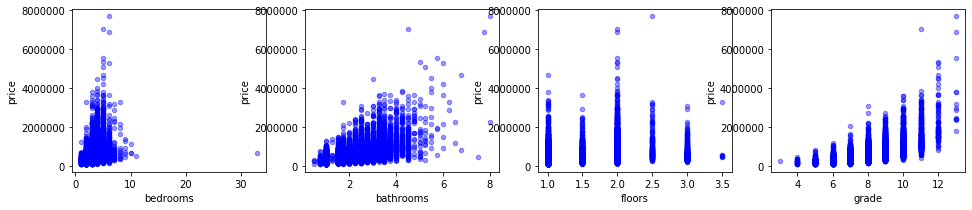

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

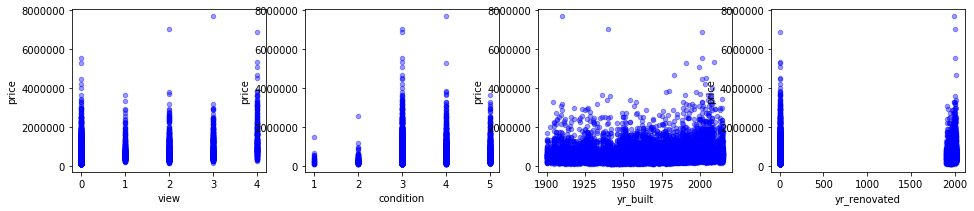

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['view', 'condition', 'yr_built', 'yr_renovated'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Encoding Categorical Variables 

In [18]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [19]:
df_cat = df[['view', 'condition', 'waterfront','grade', 'yr_built', 'yr_renovated', 'zipcode']].copy()

df_num = df[['price', 'bedrooms', 'bathrooms','floors', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']].copy()

In [20]:
df_cat['condition'] = df_cat['condition'].astype("int")

In [21]:
df_cat['waterfront'] =  df_cat['waterfront'].astype("int")

In [22]:
df_cat.columns = df_cat.columns.astype("str")

In [23]:
#changed to a string now for one hot encoding 
 
df_cat['condition'] = df['condition'].astype("str")
df_cat['waterfront'] = df['waterfront'].astype("str")
df_cat['zipcode'] = df_cat['zipcode'].astype("str")

In [24]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 7 columns):
view            21420 non-null float64
condition       21420 non-null object
waterfront      21420 non-null object
grade           21420 non-null int64
yr_built        21420 non-null int64
yr_renovated    21420 non-null float64
zipcode         21420 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [25]:
df_cat = pd.get_dummies(df_cat, drop_first=True) #pd
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 78 columns):
view              21420 non-null float64
grade             21420 non-null int64
yr_built          21420 non-null int64
yr_renovated      21420 non-null float64
condition_2       21420 non-null uint8
condition_3       21420 non-null uint8
condition_4       21420 non-null uint8
condition_5       21420 non-null uint8
waterfront_1.0    21420 non-null uint8
zipcode_98002     21420 non-null uint8
zipcode_98003     21420 non-null uint8
zipcode_98004     21420 non-null uint8
zipcode_98005     21420 non-null uint8
zipcode_98006     21420 non-null uint8
zipcode_98007     21420 non-null uint8
zipcode_98008     21420 non-null uint8
zipcode_98010     21420 non-null uint8
zipcode_98011     21420 non-null uint8
zipcode_98014     21420 non-null uint8
zipcode_98019     21420 non-null uint8
zipcode_98022     21420 non-null uint8
zipcode_98023     21420 non-null uint8
zipcode_98024     21420 non-n

# Z Scoring - mean is 0

## z= (x - mean/stdev)

In [26]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

In [27]:
df_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns)

In [28]:
df_scaled.head()

price  bedrooms  bathrooms    floors  sqft_living  sqft_lot  sqft_above  \
0 -0.866594 -0.404103  -1.454958 -0.918375    -0.982962 -0.228222   -0.737528   
1 -0.007445 -0.404103   0.171160  0.933243     0.529902 -0.189889    0.457152   
2 -0.980476 -1.484736  -1.454958 -0.918375    -1.429203 -0.123478   -1.232295   
3  0.171940  0.676531   1.146831 -0.918375    -0.134017 -0.243874   -0.894405   
4 -0.083548 -0.404103  -0.154064 -0.918375    -0.438766 -0.169710   -0.134154   

   sqft_basement  sqft_living15  sqft_lot15  
0      -0.649786      -0.945827   -0.260586  
1       0.259310      -0.435266   -0.187849  
2      -0.649786       1.067241   -0.172380  
3       1.418406      -0.916652   -0.284356  
4      -0.649786      -0.274804   -0.192822

In [29]:
df_scaled.describe()

price      bedrooms     bathrooms        floors   sqft_living  \
count  2.142000e+04  2.142000e+04  2.142000e+04  21420.000000  2.142000e+04   
mean  -1.220727e-16  1.194189e-17  2.547604e-16      0.000000  2.388379e-16   
std    1.000023e+00  1.000023e+00  1.000023e+00      1.000023  1.000023e+00   
min   -1.257709e+00 -2.565370e+00 -2.105405e+00     -0.918375 -1.864559e+00   
25%   -5.931665e-01 -4.041025e-01 -4.792872e-01     -0.918375 -7.108641e-01   
50%   -2.466261e-01 -4.041025e-01  1.711599e-01      0.007434 -1.775522e-01   
75%    2.833768e-01  6.765312e-01  4.963835e-01      0.933243  5.081345e-01   
max    1.945861e+01  3.201491e+01  7.651302e+00      3.710669  1.246956e+01   

           sqft_lot    sqft_above  sqft_basement  sqft_living15    sqft_lot15  
count  2.142000e+04  2.142000e+04   2.142000e+04   2.142000e+04  2.142000e+04  
mean   7.961263e-18 -5.838260e-17  -2.653754e-18   1.141114e-16 -2.388379e-17  
std    1.000023e+00  1.000023e+00   1.000023e+00   1.000023e+00  1.000023e+00  
min   -3.517481e-01 -1.714994e+00  -6.497857e-01  -2.318505e+00 -4.433983e-01  
25%   -2.429107e-01 -7.133933e-01  -6.497857e-01  -7.270150e-01 -2.806993e-01  
50%   -1.809311e-01 -2.789641e-01  -6.497857e-01  -2.164544e-01 -1.885435e-01  
75%   -1.068518e-01  5.174894e-01   6.002202e-01   5.566801e-01 -9.835326e-02  
max    3.939893e+01  9.194005e+00   1.030481e+01   6.158259e+00  3.139239e+01

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018BC8CB4A58>,
      dtype=object)

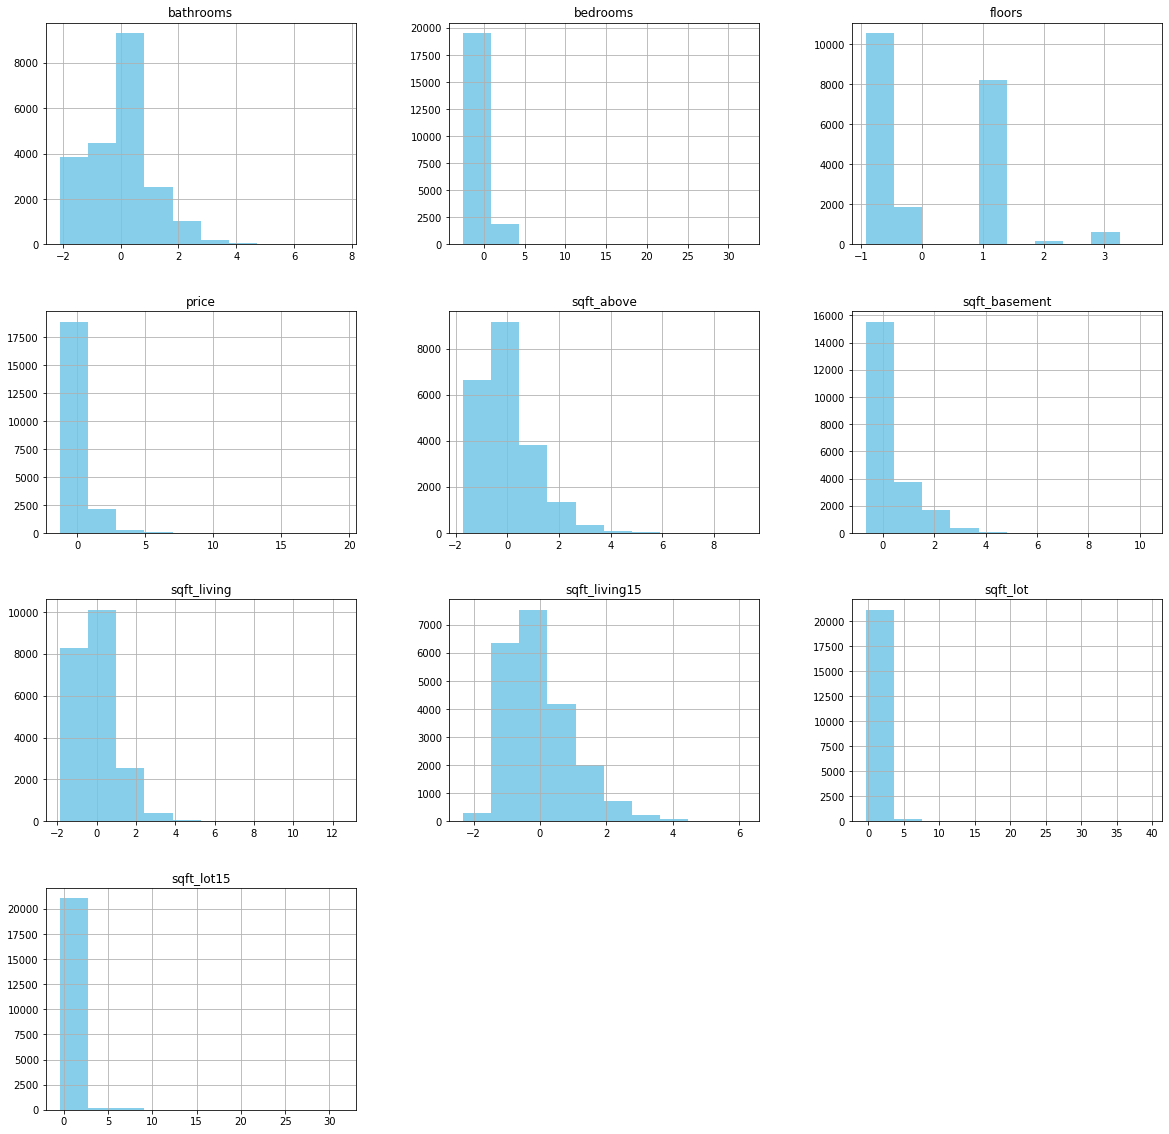

In [30]:
df_scaled.hist(figsize=(20,20), color="skyblue", lw=0)

# Drop Outliers from SQFT Variables 


In [31]:
#sqft_living 

indexNames = df[df['sqft_living'] >= 5000 ].index
df.drop(indexNames , inplace=True)

# sqft_above 

indexNames = df[df['sqft_above'] >= 4500 ].index
df.drop(indexNames , inplace=True)

#sqft_basement 

indexNames = df[df['sqft_basement'] >= 2000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_lot outliers

indexNames = df[df['sqft_lot'] >= 100000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_living15 outliers

indexNames = df[df['sqft_living15'] >= 4500 ].index
df.drop(indexNames , inplace=True)


# dropping sqft_lot15 outliers

indexNames = df[df['sqft_lot15'] >= 100000 ].index
df.drop(indexNames , inplace=True)

In [32]:
# Checking for Linear Relationships

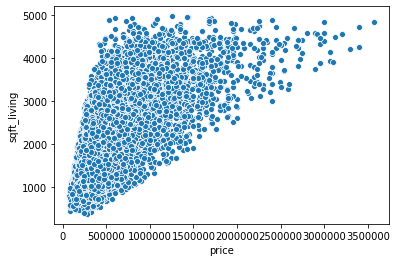

In [33]:
sns.scatterplot(x='price', y='sqft_living', data=df)

(array([ 577., 3342., 4968., 4445., 3180., 1962., 1164.,  585.,  294.,
          72.]),
 array([ 370.,  831., 1292., 1753., 2214., 2675., 3136., 3597., 4058.,
        4519., 4980.]),
 <a list of 10 Patch objects>)

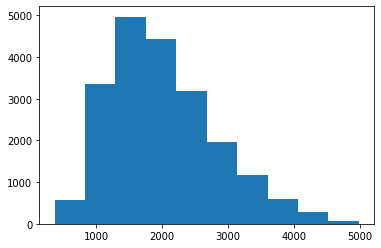

In [34]:
# Histogram of variable 

plt.hist(df['sqft_living'])

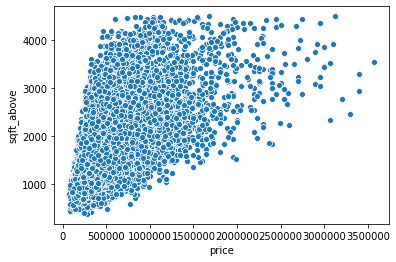

In [35]:
sns.scatterplot(x='price', y='sqft_above', data=df)

(array([ 625., 4670., 5746., 3551., 2269., 1713., 1049.,  565.,  274.,
         127.]),
 array([ 370.,  782., 1194., 1606., 2018., 2430., 2842., 3254., 3666.,
        4078., 4490.]),
 <a list of 10 Patch objects>)

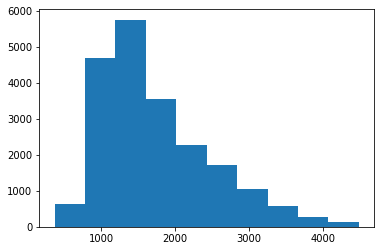

In [36]:
plt.hist(df['sqft_above'])

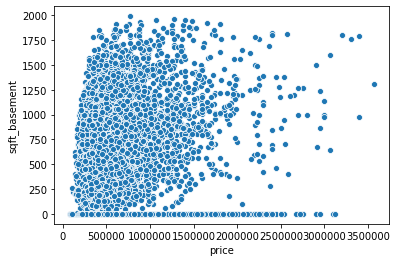

In [37]:
sns.scatterplot(x='price', y='sqft_basement', data=df)

(array([13115.,  1164.,  1559.,  1606.,  1416.,   879.,   484.,   227.,
           93.,    46.]),
 array([   0.,  199.,  398.,  597.,  796.,  995., 1194., 1393., 1592.,
        1791., 1990.]),
 <a list of 10 Patch objects>)

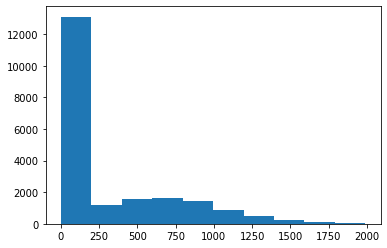

In [38]:
plt.hist(df['sqft_basement'])

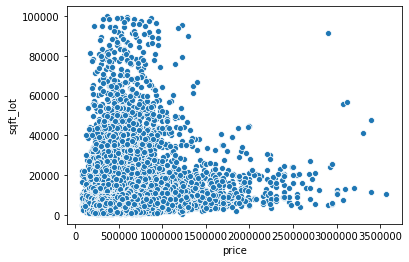

In [39]:
sns.scatterplot(x='price', y='sqft_lot', data=df)

(array([15813.,  3184.,   525.,   443.,   287.,   137.,    73.,    50.,
           39.,    38.]),
 array([  520. , 10459.6, 20399.2, 30338.8, 40278.4, 50218. , 60157.6,
        70097.2, 80036.8, 89976.4, 99916. ]),
 <a list of 10 Patch objects>)

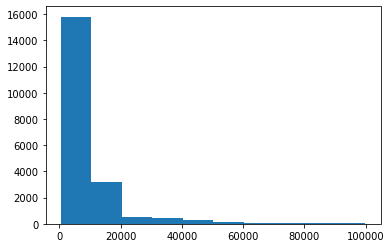

In [40]:
plt.hist(df['sqft_lot'])

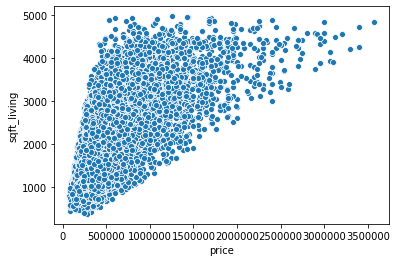

In [41]:
sns.scatterplot(x='price', y='sqft_living', data=df)

(array([ 577., 3342., 4968., 4445., 3180., 1962., 1164.,  585.,  294.,
          72.]),
 array([ 370.,  831., 1292., 1753., 2214., 2675., 3136., 3597., 4058.,
        4519., 4980.]),
 <a list of 10 Patch objects>)

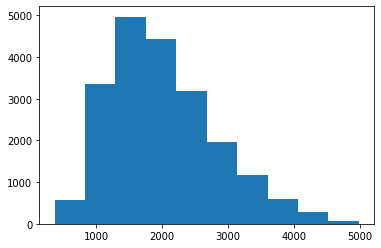

In [42]:
plt.hist(df['sqft_living'])

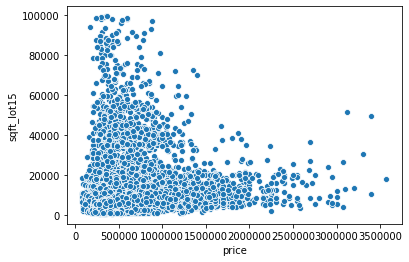

In [43]:
sns.scatterplot(x='price', y='sqft_lot15', data=df)

(array([16547.,  2769.,   383.,   437.,   222.,   109.,    45.,    29.,
           26.,    22.]),
 array([  651. , 10517.5, 20384. , 30250.5, 40117. , 49983.5, 59850. ,
        69716.5, 79583. , 89449.5, 99316. ]),
 <a list of 10 Patch objects>)

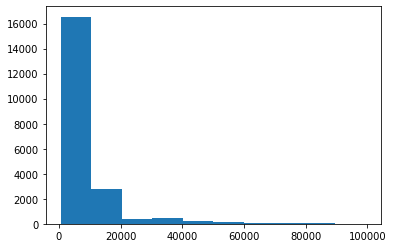

In [44]:
plt.hist(df['sqft_lot15'])

# We clearly need to log transform everything ! 

# Log functions!

In [45]:
#created a logged numerical df 

df_sqft_logs = pd.DataFrame([])
df_sqft_logs = df_num

In [46]:
df_sqft_logs['sqft_living_log'] = np.log(df_sqft_logs['sqft_living'])
df_sqft_logs['sqft_above_log'] = np.log(df_sqft_logs['sqft_above'])
df_sqft_logs['sqft_lot_log'] = np.log(df_sqft_logs['sqft_lot'])
df_sqft_logs['sqft_basement_log'] = np.log(df_sqft_logs['sqft_basement'])
df_sqft_logs['sqft_living15_log'] = np.log(df_sqft_logs['sqft_living15'])
df_sqft_logs['sqft_lot15_log'] = np.log(df_sqft_logs['sqft_lot15'])
df_sqft_logs['bathrooms'] = np.log(df_sqft_logs['bathrooms'])
df_sqft_logs['bedrooms'] = np.log(df_sqft_logs['bedrooms'])
df_sqft_logs['floors'] = np.log(df_sqft_logs['floors'])

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Linear Relationships between Numerical Data 

In [47]:
headers = list(df_sqft_logs)

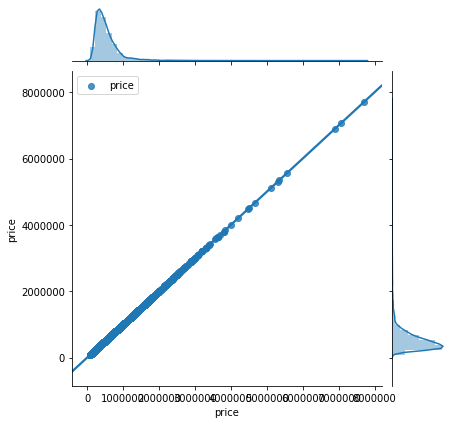

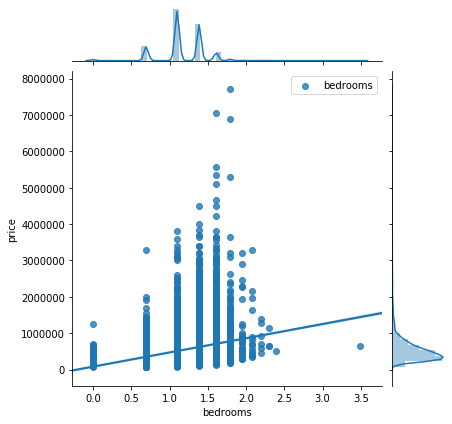

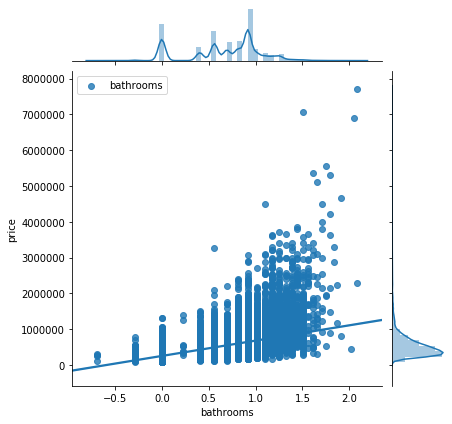

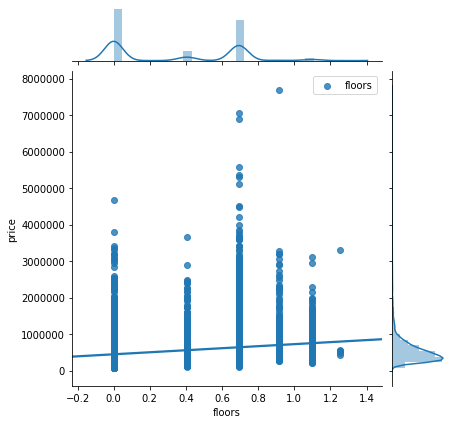

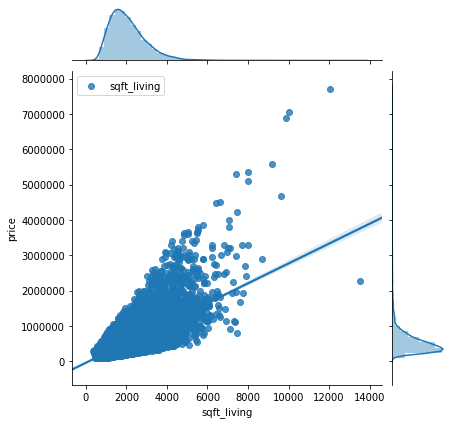

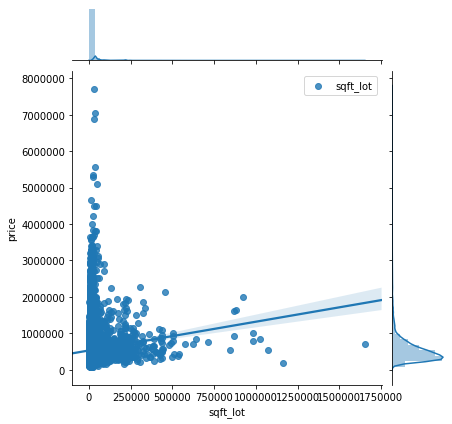

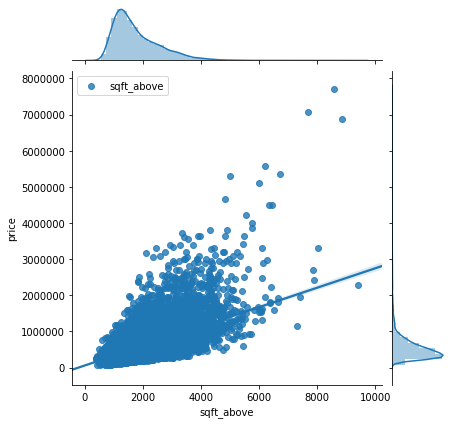

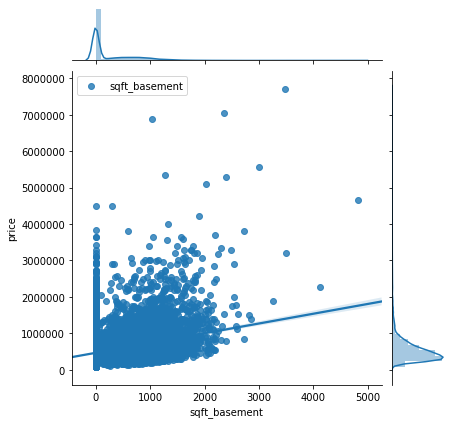

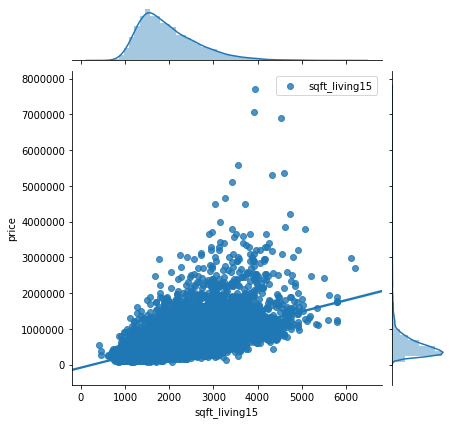

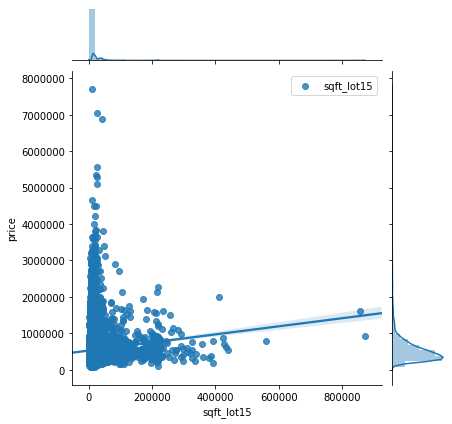

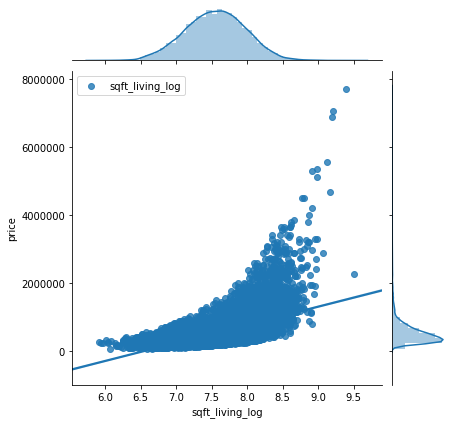

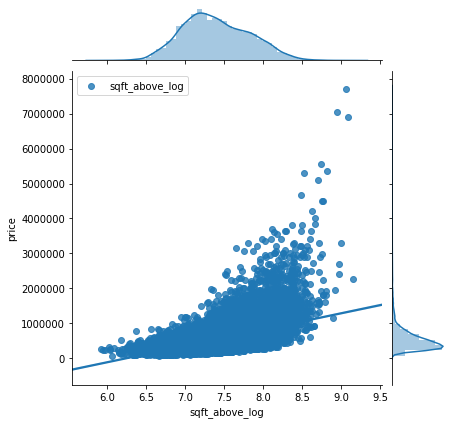

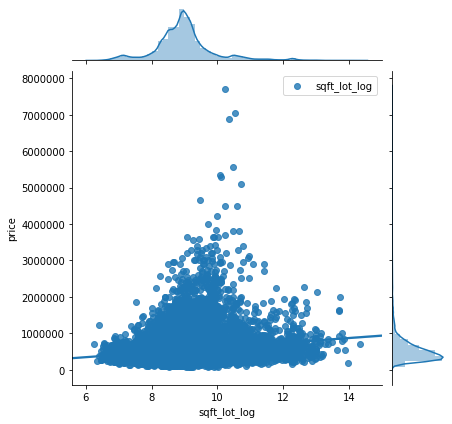

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return int(np.ceil((a.max() - a.min()) / h))


ValueError: cannot convert float NaN to integer

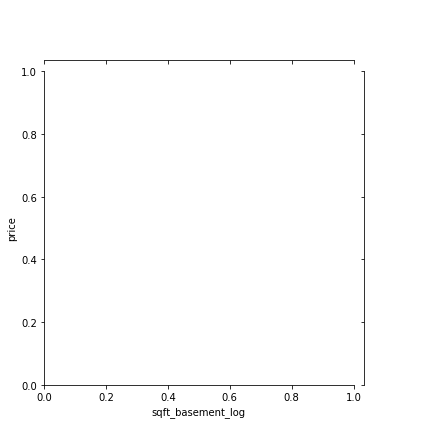

In [48]:
for column in headers:
    sns.jointplot(x=column, y='price',
                 data=df_sqft_logs,
                 kind='reg',
                 label=column,
                 )
    plt.legend()
    plt.show()

# Good place to answer 3 questions 

# Combine categorical and numerical data

In [49]:
df_combo = pd.concat([df_sqft_logs, df_cat], axis=1)
df_combo.head()  

price  bedrooms  bathrooms    floors  sqft_living  sqft_lot  sqft_above  \
0  221900.0  1.098612   0.000000  0.000000         1180      5650        1180   
1  538000.0  1.098612   0.810930  0.693147         2570      7242        2170   
2  180000.0  0.693147   0.000000  0.000000          770     10000         770   
3  604000.0  1.386294   1.098612  0.000000         1960      5000        1050   
4  510000.0  1.098612   0.693147  0.000000         1680      8080        1680   

   sqft_basement  sqft_living15  sqft_lot15  ...  zipcode_98146  \
0            0.0           1340        5650  ...              0   
1          400.0           1690        7639  ...              0   
2            0.0           2720        8062  ...              0   
3          910.0           1360        5000  ...              0   
4            0.0           1800        7503  ...              0   

   zipcode_98148  zipcode_98155  zipcode_98166  zipcode_98168  zipcode_98177  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_98178  zipcode_98188  zipcode_98198  zipcode_98199  
0              1              0              0              0  
1              0              0              0              0  
2              0              0              0              0  
3              0              0              0              0  
4              0              0              0              0  

[5 rows x 94 columns]

In [50]:
#Make sure they are categories not uint8

#what does this do ??


for cat_names in df_combo.iloc[:,11:].columns:
    df_combo[cat_names] = df_combo[cat_names].astype('category')

In [51]:
df_combo.dtypes

price             float64
bedrooms          float64
bathrooms         float64
floors            float64
sqft_living         int64
                   ...   
zipcode_98177    category
zipcode_98178    category
zipcode_98188    category
zipcode_98198    category
zipcode_98199    category
Length: 94, dtype: object

In [52]:
# Modelling Our Data

In [53]:
# OLS Regression

import statsmodels.api as sm
import statsmodels.formula.api as smf

col_names = df_combo.describe().columns[1:11] #What does this?

results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p_value ']] #creating an array of results we care about

for idx, val in enumerate(col_names):
    print('price~' + val)
    f = 'price~' + val
    model = smf.ols(formula=f, data=df_combo).fit()
    X_new = pd.DataFrame({val: [df_combo[val].min(), df_combo[val].max()]});
    preds = model.predict(X_new)
    results.append({val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]})

    print(results[idx+1])
    print(model.summary())

price~bedrooms
{0.08972602262501628, 81409.19640878573, 0.0, 389871.7046332945, 'bedrooms'}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2111.
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:22:55   Log-Likelihood:            -3.0390e+05
No. Observations:               21420   AIC:                         6.078e+05
Df Residuals:                   21418   BIC:                         6.078e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

{0.1029398459574522, 0.0, 464035.2626677881, 268.28568180479664, 'sqft_basement'}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     2458.
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:22:55   Log-Likelihood:            -3.0374e+05
No. Observations:               21420   AIC:                         6.075e+05
Df Residuals:                   21418   BIC:                         6.075e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [54]:
# Looks like sqft living has the highest followed by sqft_above

In [55]:
# Categorical variables 
col_names_cat = [f'C({c})' for c in col_names]
col_names_cat 

['C(bedrooms)',
 'C(bathrooms)',
 'C(floors)',
 'C(sqft_living)',
 'C(sqft_lot)',
 'C(sqft_above)',
 'C(sqft_basement)',
 'C(sqft_living15)',
 'C(sqft_lot15)',
 'C(sqft_living_log)']

In [56]:
formula = 'price ~' + '+'.join(col_names_cat)
mod = smf.ols(formula=formula, data = df_combo)
res = mod.fit()
res.summary()

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                      -2.160
Model:                            OLS   Adj. R-squared:             -33841.520
Method:                 Least Squares   F-statistic:                -6.383e-05
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               1.00
Time:                        22:18:14   Log-Likelihood:            -3.1723e+05
No. Observations:               21420   AIC:                         6.773e+05
Df Residuals:                       2   BIC:                         8.480e+05
Df Model:                       21417                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                         0          0        nan        nan           0           0
C(bedrooms)[T.0.6931471805599453]                 0          0        nan        nan           0           0
C(bedrooms)[T.1.0986122886681098]                 0          0        nan        nan           0           0
C(bedrooms)[T.1.3862943611198906]                 0          0        nan        nan           0           0
C(bedrooms)[T.1.6094379124341003]                 0          0        nan        nan           0           0
C(bedrooms)[T.1.791759469228055]                  0          0        nan        nan           0           0
C(bedrooms)[T.1.9459101490553132]                 0          0        nan        nan           0           0
C(bedrooms)[T.2.0794415416798357]                 0          0        nan        nan           0           0
C(bedrooms)[T.2.1972245773362196]                 0          0        nan        nan           0           0
C(bedrooms)[T.2.302585092994046]                  0          0        nan        nan           0           0
C(bedrooms)[T.2.3978952727983707]                 0          0        nan        nan           0           0
C(bedrooms)[T.3.4965075614664802]                 0          0        nan        nan           0           0
C(bathrooms)[T.-0.2876820724517809]               0          0        nan        nan           0           0
C(bathrooms)[T.0.0]                               0          0        nan        nan           0           0
C(bathrooms)[T.0.22314355131420976]               0          0        nan        nan           0           0
C(bathrooms)[T.0.4054651081081644]                0          0        nan        nan           0           0
C(bathrooms)[T.0.5596157879354227]                0          0        nan        nan           0           0
C(bathrooms)[T.0.6931471805599453]                0          0        nan        nan           0           0
C(bathrooms)[T.0.8109302162163288]                0          0        nan        nan           0           0
C(bathrooms)[T.0.9162907318741551]                0          0        nan        nan           0           0
C(bathrooms)[T.1.0116009116784799]                0          0        nan        nan           0           0
C(bathrooms)[T.1.0986122886681098]                0          0        nan        nan           0           0
C(bathrooms)[T.1.1786549963416462]                0          0        nan        nan           0           0
C(bathrooms)[T.1.252762968495368]                 0          0        nan        nan           0           0
C(bathrooms)[T.1.3217558399823195]                0          0        nan        nan           0           0
C(bathrooms)[T.1.38629436111989

In [56]:
# There is indication of strong multicolinearity

In [57]:
df_combo.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'sqft_living_log', 'sqft_above_log', 'sqft_lot_log',
       'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log', 'view',
       'grade', 'yr_built', 'yr_renovated', 'condition_1', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'waterfront_0.0',
       'waterfront_1.0', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcod

In [ ]:
df_final = df_combo.drop(['sqft_lot', 'sqft_lot_log', 'sqft_lot15', 'sqft_lot15_log', 'sqft_above_log','sqft_basement_log',  'condition_1', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'waterfront_0.0', 'waterfront_1.0', 'yr_built', 'yr_renovated'], axis=1)

df_final.columns()

In [59]:
final_cols = df_final.drop(['price'], axis=1)
formula = 'price ~' + '+'.join(final_cols)
mod = smf.ols(formula=formula, data=df_final)
res=mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     124.7
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:52:29   Log-Likelihood:            -2.8527e+05
No. Observations:               21420   AIC:                         5.723e+05
Df Residuals:                   20553   BIC:                         5.792e+05
Df Model:                         866                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                1.788e+06   2.39e+05      7.491      0.000    1.32e+06    2.26e+06
sqft_living15_log[T.6.131226489483141]  -2.187e+05   1.82e+05     -1.204      0.229   -5.75e+05    1.37e+05
sqft_living15_log[T.6.429719478039138]  -1.183e+05   1.75e+05     -0.677      0.498   -4.61e+05    2.24e+05
sqft_living15_log[T.6.507277712385012]   -5.64e+04   2.03e+05     -0.278      0.781   -4.54e+05    3.41e+05
sqft_living15_log[T.6.536691597591305]  -2.841e+05   1.72e+05     -1.655      0.098   -6.21e+05    5.23e+04
sqft_living15_log[T.6.551080335043404]  -1.249e+05   1.71e+05     -0.730      0.465    -4.6e+05    2.11e+05
sqft_living15_log[T.6.565264970035361]  -6.975e+04   1.71e+05     -0.408      0.683   -4.05e+05    2.65e+05
sqft_living15_log[T.6.579251212010101]  -1.067e+05    1.7e+05     -0.627      0.531    -4.4e+05    2.27e+05
sqft_living15_log[T.6.606650186198215]  -1.205e+05   1.42e+05     -0.847      0.397      -4e+05    1.59e+05
sqft_living15_log[T.6.620073206530356]  -6.472e+04   1.57e+05     -0.411      0.681   -3.73e+05    2.44e+05
sqft_living15_log[T.6.633318433280377]  -1.271e+05   1.57e+05     -0.809      0.418   -4.35e+05    1.81e+05
sqft_living15_log[T.6.646390514847729]  -4.638e+04   1.99e+05     -0.233      0.816   -4.36e+05    3.44e+05
sqft_living15_log[T.6.659293919683638]  -1.651e+05   1.46e+05     -1.130      0.259   -4.51e+05    1.21e+05
sqft_living15_log[T.6.672032945461067]   -3.45e+04   1.67e+05     -0.206      0.837   -3.62e+05    2.93e+05
sqft_living15_log[T.6.684611727667927]   -5.64e+04   1.55e+05     -0.363      0.717   -3.61e+05    2.48e+05
sqft_living15_log[T.6.692083742506628]    -2.4e+05   1.98e+05     -1.214      0.225   -6.27e+05    1.47e+05
sqft_living15_log[T.6.697034247666484]  -9.436e+04   1.66e+05     -0.567      0.571   -4.21e+05    2.32e+05
sqft_living15_log[T.6.709304340258298]  -3.355e+04    1.4e+05     -0.240      0.810   -3.07e+05     2.4e+05
sqft_living15_log[T.6.71901315438526]   -6.311e+04   1.97e+05     -0.321      0.749   -4.49e+05    3.23e+05
sqft_living15_log[T.6.721425700790643]  -9.422e+04   1.36e+05     -0.691      0.490   -3.62e+05    1.73e+05
sqft_living15_log[T.6.733401891837359]  -5.976e+04   1.33e+05     -0.449      0.653   -3.21e+05    2.01e+05
sqft_living15_log[T.6.745236349484363]  -9.883e+04   1.33e+05     -0.743      0.458    -3.6e+05    1.62e+05
sqft_living15_log[T.6.756932389247553]   1.242e+04   1.34e+05      0.093      0.926    -2.5e+05    2.75e+05
sqft_living15_log[T.6.76849321164863]   -6.131e+04   1.34e+05     -0.457      0.648   -3.25e+05    2.02e+05
sqft_living15_log[T.6.779921907472252]  -4.286e+04   1.32e+05     -0.326      0.744   -3.01e+05    2.15e+05
sqft_living15_log[T.6.7912214627261855] -3.773e+04   1.32e+

In [60]:
# Observations: There is huge issue with multicolinearity and this model is not reliable despite the high score 

In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
df_cat.columns

Index(['view', 'grade', 'yr_built', 'yr_renovated', 'condition_1',
       'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'waterfront_0.0', 'waterfront_1.0', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102',
       'zipcode_98103', 'zipcode_98105'

In [63]:
X_ols = X_train
X_int = sm.add_constant(X_ols)
model = sm.OLS(y_train,X_int).fit()
model.summary()

NameError: name 'X_train' is not defined